In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensornets as nets
from sklearn.metrics import confusion_matrix
from tensorflow.python.saved_model import tag_constants
import time

## List of tasks:

1. Load images as arrays
2. Load labels
3. Make x and y training + dev arrays
4. Load pre-trained architecture (eg. VGG19)
5. Train with new data
6. Make predictions
7. Set up metrics - accuracy, precision, recall. Output train and dev metrics.
8. Tune hyperparameters

In [4]:
X_file = 'X_orig.npy'
X = np.load(X_file)

In [5]:
X.shape

(10015, 224, 224, 3)

In [12]:
# Flip images and labels

m, n_H0, n_W0, n_C0 = X.shape

In [6]:
Y_file = 'Y_orig.npy'
Y = np.load(Y_file)

In [7]:
Y.shape

(10015, 7)

In [8]:
labels_loc = '../ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'

def get_Y_orig(labels_loc):
    Y_df = pd.read_csv(labels_loc)
    Y_orig = np.array(Y_df.iloc[:,1:])
    return Y_orig

Y_orig = get_Y_orig(labels_loc)

class_weights = np.array(np.mean(Y_orig, axis = 0)).astype('float32')

In [9]:
# Make x and y training + dev arrays

def get_train_index(seed, train_size, m):
    np.random.seed(seed)
    train_index = np.random.choice(m, size = int(train_size*m), replace = False)
    dev_index = list(set(range(m)) - set(train_index))
    return train_index, dev_index


In [10]:
train_size = 0.9
seed = 3


In [13]:
train_index, dev_index = get_train_index(seed, train_size, m)

In [14]:
m_train = train_index.shape[0]

In [15]:
X_train = X[train_index]
Y_train = Y[train_index]

#X_train = np.empty([m_train, 224, 224, 3])
#Y_train = np.empty([m_train, 224, 224, 3])

#for i, j in enumerate(train_index):
#    X_train[i] = X[j]
#    Y_train[i] = Y[j]
X_dev = X[dev_index]
Y_dev = Y[dev_index]

In [16]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    # ImageNet input image shape is (244, 244, 3)
    inputs = tf.placeholder(tf.float32, [None, n_H0,n_W0,n_C0], name = 'inputs_ph')

    # Output is dependent on your situation (10 for CIFAR-10)
    outputs = tf.placeholder(tf.float32, [None, n_y], name = 'outputs_ph')
    return inputs, outputs

In [29]:
def forward_prop(model, inputs):

    # model to give the name
    if model == 'resnet50':
        logits = nets.ResNet50(inputs, is_training=True, classes=7)
        middles = logits.get_outputs()[-4]
    elif model == 'squeezenet':
        logits = nets.SqueezeNet(inputs, is_training=True, classes=7)
        middles = logits.get_outputs()[-3]

    Z1 = tf.contrib.layers.flatten(middles)
    # FULLY-CONNECTED 
    Z2 = tf.contrib.layers.fully_connected(Z1, 120)#, normalizer_fn=tf.layers.batch_normalization)
    # FULLY-CONNECTED 
    Y_hat = tf.identity(tf.contrib.layers.fully_connected(Z2, 7, activation_fn = tf.nn.softmax), name = 'Y_hat') # add normalization like above later
    return Y_hat, logits

In [30]:

def compute_loss(outputs, Y_hat, class_weights):

    weights = tf.reduce_sum(class_weights * outputs, axis=1)

    # loss function applied to the last layer
    # train on the loss (Adam Optimizer is used)

    loss = tf.losses.softmax_cross_entropy(outputs, Y_hat)
    #weighted_loss = tf.reduce_mean(loss*weights)
    return loss



def optimizer(learning_rate, weighted_loss):
    train = tf.train.AdamOptimizer(learning_rate).minimize(weighted_loss)
    return train



# for measuring accuracy after forward pass
def get_acc(Y_hat, outputs):
    predictions = tf.argmax(Y_hat, 1)
    correct_pred = tf.cast(tf.equal(predictions, tf.argmax(outputs, 1)),tf.float32)
    accuracy = tf.reduce_mean(correct_pred, name='accuracy')
    return prediction, accuracy

In [31]:
ts = time.strftime('%Y%m%d%H%M')

def train_model(X_train, Y_train, X_dev, Y_dev, model, class_weights, learning_rate, batch_size, num_epochs, print_loss = True):
    tf.reset_default_graph()
    n_y = Y_train.shape[1]
    m_train, n_H0, n_W0, n_C0 = X_train.shape
    num_batches = m_train//batch_size + 1
    
    losses = []
    inputs, outputs = create_placeholders(n_H0,n_W0,n_C0,n_y)
    Y_hat, logits = forward_prop(model, inputs)
    weighted_loss = compute_loss(outputs, Y_hat, class_weights)
    train = optimizer(learning_rate, weighted_loss)
    init = tf.global_variables_initializer()
    

    with tf.Session() as sess:    
        # Initializing the variables
        sess.run(init)

        # Loading the parameters
        sess.run(logits.pretrained())

        for epoch in range(num_epochs):
            batch_loss = 0
            full_batch = range(m_train)
            for batch in range(num_batches):
                try:
                    batch_index = np.random.choice(full_batch, size=batch_size, replace = False)
                    full_batch = np.array(list(set(full_batch) - set(batch_index)))
                except ValueError:
                    batch_index = full_batch
                X_train_batch = X_train[batch_index]
                Y_train_batch = Y_train[batch_index]
                sess.run(train, feed_dict = {inputs: X_train_batch, outputs: Y_train_batch})
                temp_loss = sess.run(weighted_loss, feed_dict ={inputs: X_train_batch, outputs: Y_train_batch})
                batch_loss += temp_loss/num_batches
            losses.append(batch_loss)
            if print_loss:
                print('Loss after epoch {:2d}: {:5f}'.format(epoch+1, batch_loss))
        
        predictions = tf.identity(tf.argmax(Y_hat, 1), name = 'predictions')
        
        """
        Y_train_preds = np.empty(shape = m_train)
        for batch in range(num_batches):
            if batch != num_batches - 1:
                batch_index = range(batch*batch_size, (batch+1)*batch_size)
            else:
                batch_index = range(batch*batch_size,m_train)
            X_train_batch = X_train[batch_index]
            Y_train_batch_preds = sess.run(predictions, feed_dict ={inputs: X_train_batch})
            Y_train_preds[batch_index] = Y_train_batch_preds
            #print('Train batch {} completed'.format(batch+1))
        
        
        m_dev = X_dev.shape[0]
        num_batches = m_dev//batch_size + 1
        
        Y_dev_preds = np.empty(shape = m_dev)
        for batch in range(num_batches):
            if batch != num_batches - 1:
                batch_index = range(batch*batch_size, (batch+1)*batch_size)
            else:
                batch_index = range(batch*batch_size,m_dev)
            X_dev_batch = X_dev[batch_index]
            Y_dev_batch_preds = sess.run(predictions, feed_dict ={inputs: X_dev_batch})
            Y_dev_preds[batch_index] = Y_dev_batch_preds
            #print('Dev batch {} completed'.format(batch+1))
        
        #Y_train_preds = get_preds(X_train, model, batch_size, sess)
        #Y_dev_preds = get_preds(X_dev, model, batch_size, sess)
        
        
        """
        
        inputs_dict = {'inputs_ph': inputs, 'outputs_ph': outputs}
        outputs_dict = {'predictions': predictions, 'Y_hat': Y_hat}
        tf.saved_model.simple_save(sess, model+'-'+ts, inputs_dict, outputs_dict)
    
    return losses

In [32]:
model = 'resnet50'
learning_rate=2e-5
batch_size = 32
num_epochs = 16


losses = train_model(X_train, Y_train, X_dev, Y_dev, model, class_weights, learning_rate, batch_size, num_epochs)

Loss after epoch  1: 1.494847
Loss after epoch  2: 1.479913
Loss after epoch  3: 1.460101
Loss after epoch  4: 1.400663
Loss after epoch  5: 1.370370
Loss after epoch  6: 1.358050
Loss after epoch  7: 1.338422
Loss after epoch  8: 1.320401
Loss after epoch  9: 1.297343
Loss after epoch 10: 1.281178
Loss after epoch 11: 1.263876
Loss after epoch 12: 1.254936
Loss after epoch 13: 1.243423
Loss after epoch 14: 1.235091
Loss after epoch 15: 1.227864
Loss after epoch 16: 1.222122
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: resnet50-201811271247/saved_model.pb


In [33]:
#ts = time.strftime('%Y%m%d%H%M')
def plot_losses(model, losses, learning_rate):
    losses = np.squeeze(losses)
    num_epochs = len(losses)
    plot_title = "Learning rate =" + str(learning_rate)
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(losses)
    ax.set(title = plot_title, xlabel = 'Epochs', ylabel ='Loss', xlim = (-1,num_epochs+1))
    
    fig.savefig(model+model+'-'+ts+'TrainingLoss.png')
    plt.show()

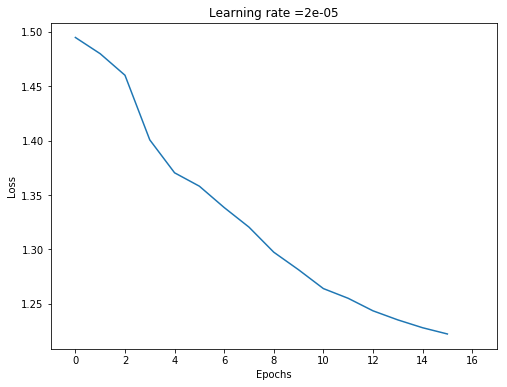

In [34]:
plot_losses(model, losses, learning_rate)

In [35]:
# Save train_index for use while prediction

train_index

array([5080,  564, 7369, ..., 8239, 2006, 8050])

In [17]:
model = 'squeezenet'
learning_rate=2e-5
batch_size = 32
num_epochs = 12

Y_train_preds_sq, Y_dev_preds_sq, losses_sq = train_model(X_train, Y_train, X_dev, Y_dev, model, class_weights, learning_rate, batch_size, num_epochs=12)

Loss after epoch  1: 0.611496
Loss after epoch  2: 0.592710
Loss after epoch  3: 0.592802
Loss after epoch  4: 0.592825
Loss after epoch  5: 0.592232
Loss after epoch  6: 0.592619
Loss after epoch  7: 0.592703
Loss after epoch  8: 0.592967
Loss after epoch  9: 0.592621
Loss after epoch 10: 0.592715
Loss after epoch 11: 0.592791
Loss after epoch 12: 0.592871


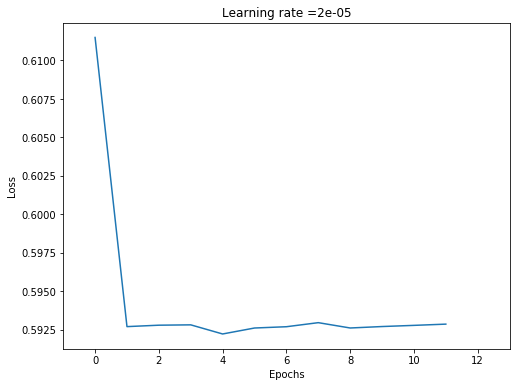

In [21]:
plot_losses(model, losses_sq, learning_rate)